In [1]:
!pip install pytorch_pretrained_bert
import os
from tqdm import tqdm_notebook as tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from pytorch_pretrained_bert import BertTokenizer
from sklearn.metrics import precision_score, recall_score, f1_score

     |████████████████████████████████| 123 kB 5.3 MB/s 
     |████████████████████████████████| 131 kB 41.5 MB/s 
     |████████████████████████████████| 8.5 MB 47.3 MB/s 
     |████████████████████████████████| 79 kB 7.8 MB/s 
     |████████████████████████████████| 138 kB 49.6 MB/s 
     |████████████████████████████████| 127 kB 44.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/My Drive/CS_project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CS_project


In [3]:
from read_sentences import read_file
train_sent, train_tagged_sent = read_file("gold_data/train.conll")
eval_sent, eval_tagged_sent = read_file("gold_data/test.conll")

tags = list(set(word_tag[1] for sent in train_tagged_sent for word_tag in sent))
",".join(tags)
tags = ["<pad>"] + tags

tag2idx = {tag:idx for idx, tag in enumerate(tags)}
idx2tag = {idx:tag for idx, tag in enumerate(tags)}

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

100%|██████████| 213450/213450 [00:00<00:00, 1799354.42B/s]


In [6]:
class SMTDataset(data.Dataset):
    def __init__(self, tagged_sents):
        sents, tags_li = [], []
        for sent in tagged_sents:
            words = [word_tag[0] for word_tag in sent]
            tags = [word_tag[1] for word_tag in sent]
            sents.append(["[CLS]"] + words + ["[SEP]"])
            tags_li.append(["<pad>"] + tags + ["<pad>"])
        self.sents, self.tags_li = sents, tags_li

    def __len__(self):
        return len(self.sents)

    def __getitem__(self, idx):
        words, tags = self.sents[idx], self.tags_li[idx]

        x, y = [], []
        is_heads = []
        for w, t in zip(words, tags):
            tokens = tokenizer.tokenize(w) if w not in ("[CLS]", "[SEP]") else [w]
            xx = tokenizer.convert_tokens_to_ids(tokens)

            is_head = [1] + [0]*(len(tokens) - 1)

            t = [t] + ["<pad>"] * (len(tokens) - 1)
            yy = [tag2idx[each] for each in t]

            x.extend(xx)
            is_heads.extend(is_head)
            y.extend(yy)

        assert len(x)==len(y)==len(is_heads), "len(x)={}, len(y)={}, len(is_heads)={}".format(len(x), len(y), len(is_heads))

        seqlen = len(y)

        words = " ".join(words)
        tags = " ".join(tags)
        return words, x, is_heads, tags, y, seqlen

In [7]:
def pad(batch):
    f = lambda x: [sample[x] for sample in batch]
    words = f(0)
    is_heads = f(2)
    tags = f(3)
    seqlens = f(-1)
    maxlen = np.array(seqlens).max()

    f = lambda x, seqlen: [sample[x] + [0] * (seqlen - len(sample[x])) for sample in batch]
    x = f(1, maxlen)
    y = f(-2, maxlen)


    f = torch.LongTensor

    return words, f(x), is_heads, tags, f(y), seqlens

In [8]:
from pytorch_pretrained_bert import BertModel

In [9]:
class Net(nn.Module):
    def __init__(self, vocab_size=None):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')

        self.fc = nn.Linear(768, vocab_size)
        self.device = device

    def forward(self, x, y):

        x = x.to(device)
        y = y.to(device)
        
        if self.training:
            self.bert.train()
            encoded_layers, _ = self.bert(x)
            enc = encoded_layers[-1]
        else:
            self.bert.eval()
            with torch.no_grad():
                encoded_layers, _ = self.bert(x)
                enc = encoded_layers[-1]
        
        logits = self.fc(enc)
        y_hat = logits.argmax(-1)
        return logits, y, y_hat

In [10]:
def train(model, iterator, optimizer, criterion):
    model.train()
    for i, batch in enumerate(iterator):
        words, x, is_heads, tags, y, seqlens = batch
        _y = y
        optimizer.zero_grad()
        logits, y, _ = model(x, y)

        logits = logits.view(-1, logits.shape[-1])
        y = y.view(-1)

        loss = criterion(logits, y)
        loss.backward()

        optimizer.step()

        if i%10==0:
            print("step: {}, loss: {}".format(i, loss.item()))

In [11]:
def eval(model, iterator):
    model.eval()

    Words, Is_heads, Tags, Y, Y_hat = [], [], [], [], []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            words, x, is_heads, tags, y, seqlens = batch

            _, _, y_hat = model(x, y)

            Words.extend(words)
            Is_heads.extend(is_heads)
            Tags.extend(tags)
            Y.extend(y.numpy().tolist())
            Y_hat.extend(y_hat.cpu().numpy().tolist())

    # get results and save
    with open("result.txt", 'w') as fout:
        for words, is_heads, tags, y_hat in zip(Words, Is_heads, Tags, Y_hat):
            y_hat = [hat for head, hat in zip(is_heads, y_hat) if head == 1]
            preds = [idx2tag[hat] for hat in y_hat]
            assert len(preds)==len(words.split())==len(tags.split())
            for w, t, p in zip(words.split()[1:-1], tags.split()[1:-1], preds[1:-1]):
                fout.write("{} {} {}\n".format(w, t, p))
            fout.write("\n")
            
    # calculate metrics
    y_true =  np.array([tag2idx[line.split()[1]] for line in open('result', 'r').read().splitlines() if len(line) > 0])
    y_pred =  np.array([tag2idx[line.split()[2]] for line in open('result', 'r').read().splitlines() if len(line) > 0])
    
    print("Precision: ", precision_score(y_true, y_pred, average="macro"))
    print("Recall: ", recall_score(y_true, y_pred, average="macro"))
    print("F-score: ", f1_score(y_true,y_pred, average="macro"))

In [12]:
model = Net(vocab_size=len(tag2idx))
model.to(device)
model = nn.DataParallel(model)

100%|██████████| 404400730/404400730 [00:12<00:00, 31304295.82B/s]


In [13]:
train_dataset = SMTDataset(train_tagged_sent)
eval_dataset = SMTDataset(eval_tagged_sent)

train_iter = data.DataLoader(dataset=train_dataset,
                             batch_size=16,
                             shuffle=True,
                             num_workers=1,
                             collate_fn=pad)
test_iter = data.DataLoader(dataset=eval_dataset,
                             batch_size=16,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

optimizer = optim.Adam(model.parameters(), lr = 0.0001)

criterion = nn.CrossEntropyLoss(ignore_index=0)

In [14]:
train(model, train_iter, optimizer, criterion)
eval(model, test_iter)

step: 0, loss: 4.221718788146973
step: 10, loss: 1.9698323011398315
step: 20, loss: 1.3595689535140991
step: 30, loss: 0.8376814723014832
step: 40, loss: 0.42178821563720703
step: 50, loss: 0.45406949520111084
step: 60, loss: 0.22090063989162445
step: 70, loss: 0.41740065813064575
step: 80, loss: 0.21044233441352844
step: 90, loss: 0.1638862043619156
step: 100, loss: 0.2115311324596405
step: 110, loss: 0.2916991710662842
step: 120, loss: 0.2925538718700409
step: 130, loss: 0.2410266101360321
step: 140, loss: 0.05338044464588165
step: 150, loss: 0.16439655423164368
step: 160, loss: 0.23280063271522522
step: 170, loss: 0.15207718312740326
step: 180, loss: 0.13605284690856934
step: 190, loss: 0.1449507623910904
step: 200, loss: 0.02251405455172062
step: 210, loss: 0.07322980463504791
step: 220, loss: 0.15492567420005798
step: 230, loss: 0.07893476635217667
step: 240, loss: 0.14833208918571472
step: 250, loss: 0.05462279170751572
step: 260, loss: 0.1867348700761795
step: 270, loss: 0.05058

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
open('result', 'r').read().splitlines()[:250]

['A DIS DIS',
 'brown COL COL',
 'dog CON CON',
 'and GRP GRP',
 'a DIS DIS',
 'grey COL COL',
 'dog CON CON',
 'are NOW NOW',
 'fighting EXG EXG',
 'in REL REL',
 'the DEF DEF',
 'snow CON CON',
 '',
 'A DIS DIS',
 'woman CON CON',
 'in REL REL',
 'a DIS DIS',
 'white COL COL',
 'dress CON CON',
 'and GRP GRP',
 'a DIS DIS',
 'woman CON CON',
 'in REL REL',
 'a DIS DIS',
 'blue COL COL',
 'dress CON CON',
 'are NOW NOW',
 'standing EXG EXG',
 'on REL REL',
 'a DIS DIS',
 'stage CON CON',
 '',
 'There NIL NIL',
 'is NOW NOW',
 'no NOT NOT',
 'man CON CON',
 'playing EXG EXG',
 'two QUC QUC',
 'keyboards CON CON',
 '',
 'There NIL NIL',
 'is NOW NOW',
 'no NOT NOT',
 'person CON CON',
 'cutting EXG EXG',
 'some DIS DIS',
 'ginger CON CON',
 '',
 'You PRO PRO',
 'are NOW NOW',
 'screwed EXS IST',
 '. NIL NIL',
 '',
 'This PRX PRX',
 'is ENS ENS',
 'a DIS DIS',
 'man-made IST CON',
 'language CON CON',
 '. NIL NIL',
 '',
 'which QUE QUE',
 'singer ROL ROL',
 'do NOW NOW',
 'you PRO PRO',


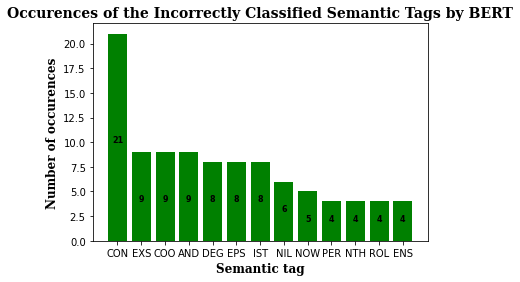

In [16]:
from collections import Counter, OrderedDict
import matplotlib.pylab as plt

file = open("result.txt", "r")

words, correct_class, wrong_class = [], [], []

for line in file:
  line = line.split()
  if len(line) > 1:
    if line[1] != line[2]:
      words.append(line[0])
      correct_class.append(line[1])
      wrong_class.append(line[2])      
file.close()

correct_counts = Counter(correct_class)
wrong_counts = Counter(wrong_class)

correct_counts = dict(sorted(correct_counts.items(), key=lambda item: item[1], reverse=True))

x = [] # keys
y = [] # values
for key, value in correct_counts.items():
	if value >= 4:
		x.append(key)
		y.append(value)
plt.bar(x,y, color = 'green')

for i in range(len(x)):
    plt.text(i, y[i]//2, y[i], ha = 'center', fontsize = 8, fontweight='bold')


plt.title('Occurences of the Incorrectly Classified Semantic Tags by BERT', fontsize = 14, fontweight='bold', fontfamily='serif')
plt.xlabel('Semantic tag', fontweight='bold', fontfamily='serif', fontsize = 12)
plt.ylabel('Number of occurences', fontweight='bold', fontfamily='serif', fontsize = 12)
#plt.savefig("incorrectly_classified_baseline.png")
plt.show()
